In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
import time
import h5py
sys.path.insert(1, '/home/nicolas/code/src')
sys.path.insert(1, '/home/nicolas/code/data')

from TMCRBM import TMCRBM
from scipy.integrate import simps
from scipy import stats


device = torch.device("cuda")
dtype = torch.float
torch.set_num_threads(4)
data = torch.tensor(np.genfromtxt('../dataset/data_2d.dat'), device = device, dtype = dtype)

data = (data+1)/2

In [7]:
f = h5py.File("../model/AllParametersRBM_NGibbs_50_Nh100_Ns1000_Nmb600_Nepoch1000_lr_0.01_TMCTEST2D_updCentered_TRUE.h5", 'r')
alltimes = np.array(f['alltime'])
alltimes = []
for t in f['alltime'][:]:
    if 'W'+str(t) in f:
        alltimes.append(t)

In [3]:
t = 4868
lr = 0.01
NGibbs = 100
annSteps = 0
mb_s = 600
num_pcd = 100
Nh = torch.tensor(f['W0']).shape[0]
Nv = data.shape[1]
ep_max = 10
w_hat = torch.linspace(0,1,steps=100)
_, S_d, V = torch.svd(data)
V0 = V[:,0]
N = 20000
it_mean = 50
myRBM = TMCRBM(num_visible=Nv,
            num_hidden=Nh,
            device=device,
            lr=lr,
            gibbs_steps=NGibbs,
            UpdCentered=False,
            mb_s=mb_s,
            num_pcd=num_pcd,
            N = N,
            it_mean = it_mean,
           )

myRBM.W = torch.tensor(f['W'+str(t)], device = myRBM.device)
myRBM.hbias = torch.tensor(f['hbias'+str(t)], device = myRBM.device)
myRBM.vbias = torch.tensor(f['vbias'+str(t)], device = myRBM.device)
_, _, V = torch.svd(myRBM.W)
if torch.mean(V[:,0])<0:
    V = -V
f.close()

In [4]:
# w_hat : nDim x nb_point
# V : matrice de projection
def TMCSampleND(v, w_hat, N, V, it_mcmc=100, it_mean=50, ß=1):
    #print("Initialisation")
    vtab = torch.zeros(v.shape, device=device)
    v_curr = v
    norm = 1/(v_curr.shape[0]**0.5)
    w_curr = (torch.mm(v_curr.T, V)*norm)[:,:w_hat.shape[0]]
    index = torch.randperm(v_curr.shape[0])
    for t in range(it_mcmc):
        #print('init it')
        print(t)
        h_curr, _ = myRBM.SampleHiddens01(v_curr)
        h_i = (torch.mm(myRBM.W.T, h_curr)+myRBM.vbias.reshape(v.shape[0],1)) # Nv x Ns
        w_next = w_curr.clone()
        
        v_next = torch.clone(v_curr)
        index = torch.randperm(v_curr.shape[0])
        for idx in range(v_curr.shape[0]):
            s = time.time()
            i = idx
            v_next[i,:] = 1-v_curr[i,:]
            for j in range(w_next.shape[1]):
                w_next[:,j] += ((2*v_next[i,:]-1)*V[i,j]*norm)
                
            # On calcul -DeltaE
            ΔE = ß*((2*v_next[i,:]-1)*h_i[i,:])-(N/2)*(torch.sum((w_hat.T-w_next)**2, dim=1)-torch.sum((w_hat.T-w_curr)**2, dim=1))

            tir = torch.rand(v_curr.shape[1],1, device = torch.device("cuda")).squeeze()
            prob = torch.exp(ΔE).squeeze()
            v_curr[i,:] = torch.where(tir<prob, v_next[i,:], v_curr[i,:])
            v_next[i,:] = torch.where(tir<prob, v_next[i,:], 1-v_next[i,:])
            neg_index = torch.ones(w_curr.shape[0], dtype = bool)
            index = torch.where(tir<prob)[0]
            neg_index[index] = False
            w_curr[index,:]=  w_next[index, :]
            w_next[neg_index,:] =  w_curr[neg_index,:]
            #print(time.time()-s)
        if (t>= (it_mcmc-it_mean)):
            vtab += v_curr
    vtab = vtab*(1/it_mean)
    vtab = vtab.reshape(Nv, nb_point, nb_chain)
    v_curr = v_curr.reshape(Nv, nb_point, nb_chain)
    h_curr = h_curr.reshape(Nh, nb_point, nb_chain)
    return v_curr, h_curr, vtab

In [5]:
_, _, V_g = torch.svd(myRBM.W)
if torch.mean(V_g[:,0])<0:
    V_g = -V_g
proj_data =torch.mm(data, V_g).cpu()/myRBM.Nv**0.5


In [6]:
nb_chain = 10 # Nb de chaines pour chaque w_hat
it_mcmc = 100 # Nb it_mcmc pour chaque chaine
it_mean = 90 # Nb it considérée pour la moyenne temporelle de chaque chaine
nDim = 2
nb_point_dim = torch.tensor([125, 125]) # -> doit avoir autant de terme que la valeur de nDim
N = 20000 # Contrainte
#nb_point_x = 125 # Nb de points de discrétisation pour w_hat
#nb_point_y = 125
width_plus = 0.2
limits = torch.zeros((2, nDim))
for i in range(nDim):
    limits[0, i] = proj_data[:,i].min()-width_plus
    limits[1, i] = proj_data[:,i].max()+width_plus

xmin = proj_data[:,0].min()-width_plus
xmax = proj_data[:,0].max()+width_plus
ymin = proj_data[:,1].min()-width_plus
ymax = proj_data[:,1].max()+width_plus
nb_point = nb_point_dim.prod()

In [7]:
x_grid = np.linspace(limits[0,0], limits[1,0], nb_point_dim[0])
x_grid = np.array([x_grid for i in range(nb_point_dim[1])])
x_grid = x_grid.reshape(nb_point)
y_grid = []
y_d = np.linspace(limits[0,1], limits[1,1], nb_point_dim[1])
for i in range(nb_point_dim[0]):
    for j in range(nb_point_dim[1]):
        y_grid.append(y_d[i])
grid = torch.tensor([x_grid, y_grid], device = device, dtype = dtype)
grid.shape

torch.Size([2, 15625])

In [8]:
start = torch.bernoulli(torch.rand(myRBM.Nv, nb_chain*nb_point, device = device))
# w_hat = torch.dot(start.T, V)[0:,]
w_hat_b = grid
w_hat = torch.zeros((2, nb_chain*nb_point), device = device)
for i in range(nb_point):
    for j in range(nb_chain):
        w_hat[:,i*nb_chain+j] = w_hat_b[:,i]
tmpv, tmph, vtab = TMCSampleND(start, w_hat, N, V_g, it_mcmc = it_mcmc, it_mean=it_mean)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [12]:
newy = torch.mm(torch.mean(vtab, dim = 2).T, V_g)[:,:nDim]/Nv**0.5
#y = torch.mm(vtab.T, V_g)[:,:nDim]/myRBM.Nv**0.5
#newy = torch.tensor([torch.mean(y[i*nb_chain:i*nb_chain+nb_chain,:], dim = 0).cpu().numpy() for i in range(nb_point)])
#w_hat = w_hat.cpu().numpy()
#w_hat_b = w_hat_b.cpu().numpy()

In [14]:
grad_pot = newy.T-w_hat_b
square = torch.zeros(2, nb_point_dim[0], nb_point_dim[1])
w_hat_tmp = np.zeros((2, nb_point_dim[0], nb_point_dim[1]))
for i in range(0,grad_pot.shape[1], nb_point_dim[0]):
        #print("I : ", i/nb_point_x)
        #print("s : ", (i*nb_point_x))
        #print("e : ", (i*nb_point_x+nb_point_x))
        w_hat_tmp[:,:,int(i/nb_point_dim[0])] = w_hat_b[:, i:(i+nb_point_dim[0])].cpu().numpy()
        square[:,:, int(i/nb_point_dim[0])] = grad_pot[:,i:(i+nb_point_dim[0])]
#square = grad_pot.reshape(2,nb_point_x, nb_point_y)
w_hat_dim = []
for i in range(nDim):
    w_hat_dim.append(np.linspace(limits[0,i], limits[1,i], nb_point_dim[i]))

#calcul de l'intégrale sur w_1
res_x = np.zeros((nb_point_dim[0],nb_point_dim[1]))
for j in range(1,nb_point_dim[1]):
    for i in range(1, nb_point_dim[0]):
        res_x[i,j] = simps(square[0,:i,j].cpu().numpy(), w_hat_dim[0][:i])

res_x = res_x


#calcul de l'intégrale sur w_2
res_y = np.zeros((nb_point_dim[0], nb_point_dim[1]))
for i in range(1, nb_point_dim[0]):
    for j in range(1, nb_point_dim[1]):
        res_y[i,j] = simps(square[1,i,:j].cpu().numpy(), w_hat_dim[1][:j])
res_y = res_y
pot = res_x + res_y
pot = pot.T
res = np.exp(N*(pot-np.max(pot)))

In [15]:
#LE CALCUL DE LA CONSTANTE EST CORRECT
const = np.zeros(res.shape[0]-1)
for i in range(1, res.shape[0]):
    const[i-1] = simps(res[:,i], w_hat_dim[1])
const = simps(const, w_hat_dim[1][:-1])
p_m = res/const

In [16]:
tmp = np.zeros(p_m.shape[0]-1)
for i in range(1, p_m.shape[0]-1):
    tmp[i-1] = simps(p_m[:,i], w_hat_dim[1])
tmp = simps(tmp, w_hat_dim[1][:-1])
print("Integrale de la proba sur l'espace : ", tmp)

Integrale de la proba sur l'espace :  0.9999999999996536


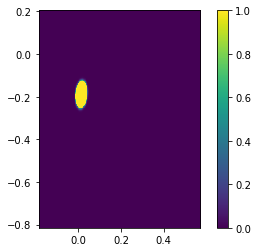

In [17]:
plt.imshow(p_m, vmax = 1, extent = [limits[0,0], limits[1,0], limits[0,1], limits[1,1]])
plt.colorbar()

In [48]:
s_i = torch.stack([torch.mean(
            tmpv[:, i*nb_chain:i*nb_chain+nb_chain], dim=1) for i in range(nb_point)], 1)
tau_a = torch.stack([torch.mean(
    tmph[:, i*nb_chain:i*nb_chain+nb_chain], dim=1) for i in range(nb_point)], 1)

s_i_square = torch.zeros([s_i.shape[0], nb_point_dim[0], nb_point_dim[1]])
tau_a_square = torch.zeros([tau_a.shape[0], nb_point_dim[0], nb_point_dim[1]])

for i in range(0,grad_pot.shape[1], nb_point_dim[0]):
    s_i_square[:,:,int(i/nb_point_dim[0])] = s_i[:, i:(i+nb_point_dim[0])]
    tau_a_square[:,:,int(i/nb_point_dim[0])] = tau_a[:, i:(i+nb_point_dim[0])]
    

In [49]:
s_i_square.shape

torch.Size([1000, 125, 125])

In [51]:
p_m = torch.tensor(p_m)

In [71]:
tmpres = torch.zeros(1000,125)
tmps_i_square = p_m*s_i_square
s_i_fin = torch.zeros(1000)
for i in range(nb_point_dim[0]):
    tmpres[:,i] = torch.trapz(tmps_i_square[:,i,:-1], torch.tensor(w_hat_dim[1][:-1]))
s_i_fin = torch.trapz(tmpres[:,:-1], torch.tensor(w_hat_dim[0][:-1]))


In [73]:
tau_a.shape

torch.Size([100, 15625])